In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

### **Import Module**

In [2]:
import tensorflow as tf

import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

keras.__version__

'3.8.0'

# FMNIST-RNN with Multi-Head Attention  
## 조금 어려운 Fashion MNIST 사용   
## RNN 모델을 키우고
## Attention Layer가 의미가 있는지 검토  

### **DataSet**

#### Load

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
ps(x_train)
ps(y_train)

<<>> Shape(60000, 28, 28)
<<>> Shape(60000,)


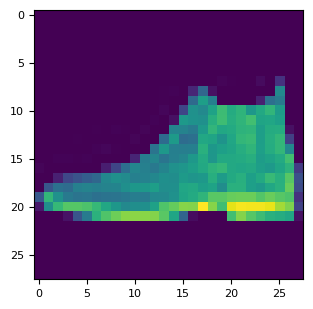

In [5]:
plt.imshow(x_test[0])
plt.show()

## Plot history

In [6]:
def plt_history(historys,names,min_acc=0.6):
    mins =[]
    title_name = ""
    for i,h in enumerate(historys):
        title_name += f"({names[i]}:{max(h['val_acc']):.3f})"
    plt.figure(figsize=(10,3))
    plt.subplot(121)

    for i,h in enumerate(historys):
#        plt.plot(h['acc'], label=names[i])
        plt.plot(h['val_acc'], label=names[i]+"_val")
    plt.title("Accuracy\n"+title_name)
    plt.ylim(min_acc, 0.95)
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.title("loss")
    for i,h in enumerate(historys):
#        plt.plot(h['loss'], label=names[i])
        plt.plot(h['val_loss'], label=names[i]+"_val")
    #plt.ylim(0.1, 1)
    plt.semilogy()
    plt.legend()
    plt.grid()

    plt.show()

In [7]:
lstm_units = 128 # 32에서 128로 증가 시킴

In [8]:
# 주요 변수 정의
features = 28   #pixels
time_steps = 28 #lines
in_dense = 14   # 임의 값
out_dense = 10  # 출력은 숫자(0~9) 확률

## **Model-1** : Basic LSTM Model

Model: "Basic-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 28, 14)              │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          73,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,912 (292.62 KB)

 Trainable params: 74,912 (292.62 KB)

 Non-trainable params: 0 (0.00 B)

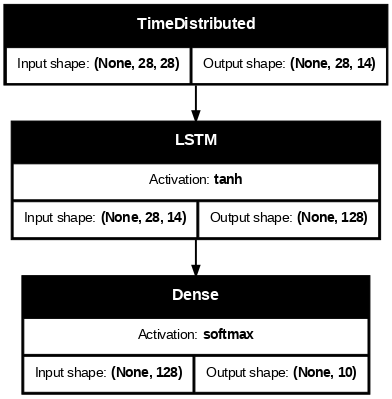

In [9]:
## Model-1 설계 : many to one 기본 모델
def model_1():
    return keras.models.Sequential([
          keras.Input(shape=(time_steps, features)),
          layers.TimeDistributed(layers.Dense(in_dense)),
          layers.LSTM(lstm_units,dropout=0.1),         # LSTM
          layers.Dense(out_dense, activation='softmax')
    ],name="Basic-RNN")

model = model_1() # Model Instance

model.summary()
keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [10]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [11]:
%%time
batch_size = 512
history_1 = model.fit(x_train, y_train,   #(60000,28,28),(60000,)
          validation_data=(x_test, y_test), #(10000,28,28),(10000,)
          batch_size=batch_size,
          epochs=30)
# Wall time: 31.5 s

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.4773 - loss: 1.4572 - val_acc: 0.7364 - val_loss: 0.6999
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7617 - loss: 0.6365 - val_acc: 0.7781 - val_loss: 0.5981
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7979 - loss: 0.5418 - val_acc: 0.8016 - val_loss: 0.5313
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8157 - loss: 0.4963 - val_acc: 0.8186 - val_loss: 0.4970
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8276 - loss: 0.4586 - val_acc: 0.8197 - val_loss: 0.4873
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8382 - loss: 0.4349 - val_acc: 0.8330 - val_loss: 0.4601
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8440 - loss: 0.4197 - val_acc: 0.8420 - val_loss: 0.4262
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8527 - loss: 0.3959 - val_acc: 0.8491 - val_loss: 0.4103
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

Wall time: 22.6 s


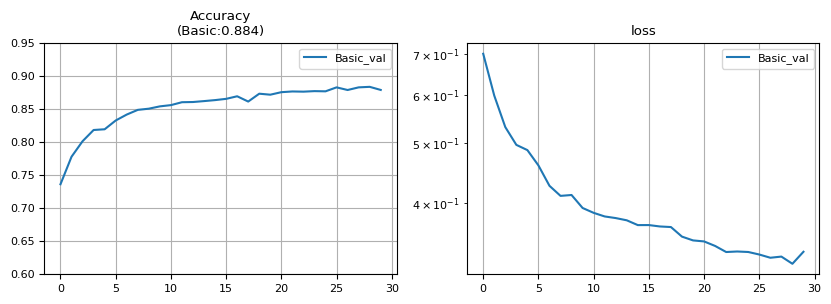

In [12]:
titles=["Basic"]
plt_history([history_1.history],titles)

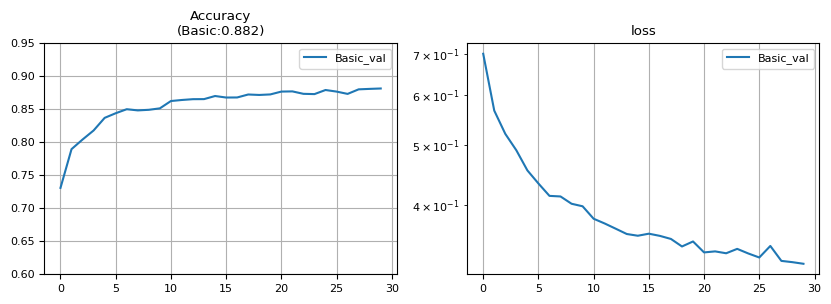

## **Model-2** : Bidirectional Model

Model: "Bidirectional-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, 28, 14)              │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         146,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,408 (583.62 KB)

 Trainable params: 149,408 (583.62 KB)

 Non-trainable params: 0 (0.00 B)

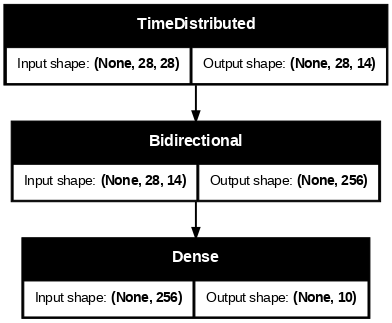

In [13]:
## Model-2 설계 : Bidirectional 추가
def model_2():
    model = keras.models.Sequential(name="Bidirectional-RNN")
    model.add(keras.Input(shape=(time_steps, features)))
    model.add(layers.TimeDistributed(layers.Dense(in_dense)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units,dropout=0.1)))
    model.add(layers.Dense(out_dense, activation='softmax'))
    return model

model = model_2()
model.summary()
keras.utils.plot_model(model,'model.png',show_shapes=True,dpi=70)


In [14]:
# model_Bi : bi-RNN
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [15]:
%%time
batch_size = 512
history_2 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.5194 - loss: 1.3586 - val_acc: 0.7714 - val_loss: 0.6061
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.7981 - loss: 0.5388 - val_acc: 0.8051 - val_loss: 0.5147
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8227 - loss: 0.4728 - val_acc: 0.8223 - val_loss: 0.4785
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8365 - loss: 0.4342 - val_acc: 0.8371 - val_loss: 0.4349
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8489 - loss: 0.4054 - val_acc: 0.8449 - val_loss: 0.4156
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8558 - loss: 0.3855 - val_acc: 0.8429 - val_loss: 0.4145
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8632 - loss: 0.3725 - val_acc: 0.8505 - val_loss: 0.3955
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8690 - loss: 0.3546 - val_acc: 0.8554 - val_loss: 0.3883
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

Wall time: 33.4 s


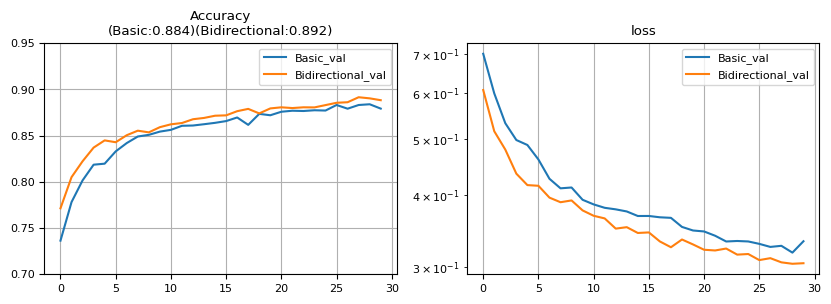

In [16]:
titles=["Basic","Bidirectional"]
plt_history([history_1.history,history_2.history],titles,0.7)

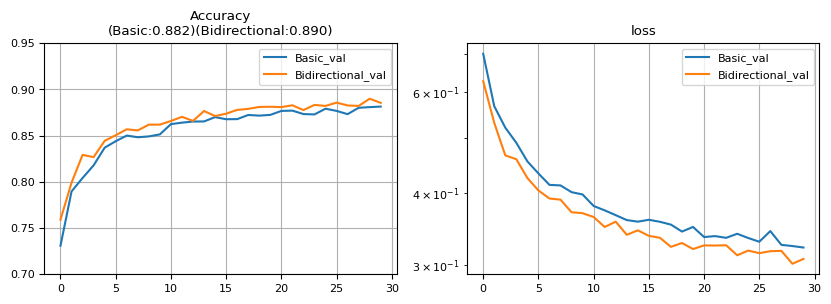

## Model-3.3 Scaled Dot-Product Attention  
### query로 부터 key를

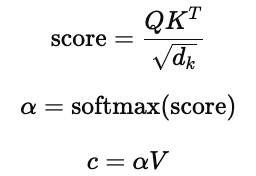

In [17]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
    # query: (batch_size, hidden_dim), values: (batch_size, time_steps, hidden_dim)
    def call(self, query, values):
        d_k = tf.cast(tf.shape(query)[-1], tf.float32)
        query_expanded = tf.expand_dims(query, axis=1)      #(bs, 1, hidden_dim)
        # (bs, 1, hidden_dim) · (bs, time_steps, hidden_dim)^T → (bs, 1, time_steps)
        score = tf.matmul(query_expanded, values, transpose_b=True) / tf.math.sqrt(d_k)
        attention_weights = tf.nn.softmax(score, axis=-1)    # (bs, 1, time_steps)
        context_vector = tf.matmul(attention_weights, values)# (bs, 1, hidden_dim)
        context_vector = tf.squeeze(context_vector, axis=1)  #(bs, hidden_dim)
        return context_vector, attention_weights

In [18]:
## LSTM 마지막 상태를 Query로 사용
def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers): # x:(bs, time_steps, hidden_size)
        x = layers.Bidirectional(
            layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    query = layers.Lambda(lambda t: t[:, -1, :])(x) # 마지막 time_steps을 query로 사용

    # Attention 적용
    attention_layer = ScaledDotProductAttention()
    context_vector, attn_weights = attention_layer(query, x) # (Q,V(K))

    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=[outputs])
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 28, 14)         │            406 │ input_layer_2[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 28, 256)        │        146,432 │ time_distributed_2[0]… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ [(None, 256), (None,   │              0 │ lambda[0][0],          │
│ (ScaledDotProductAttenti… │ 1, 28)]                │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ scaled_dot_product_at… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 10)             │          2,570 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 149,408 (583.62 KB)

 Trainable params: 149,408 (583.62 KB)

 Non-trainable params: 0 (0.00 B)

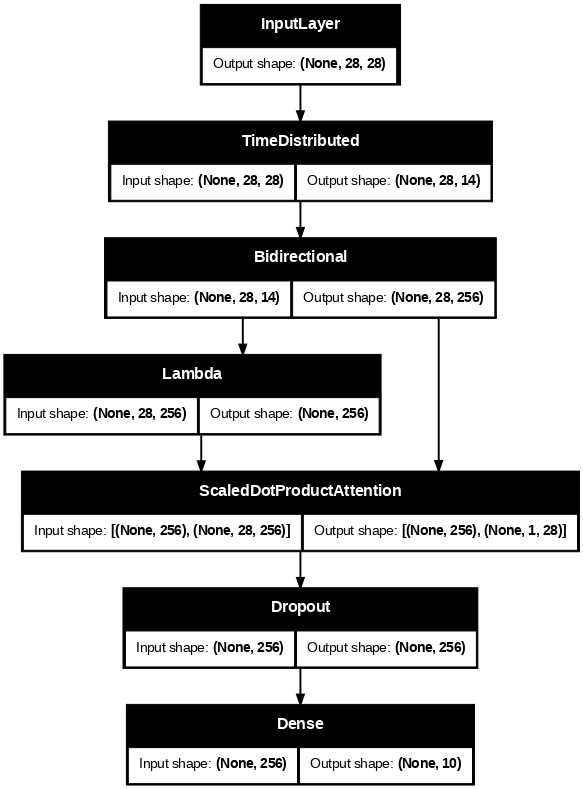

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=70)

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [21]:
%%time
batch_size = 512
history_3_3 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.4682 - loss: 1.4701 - val_acc: 0.7583 - val_loss: 0.6491
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.7772 - loss: 0.5984 - val_acc: 0.8032 - val_loss: 0.5370
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8143 - loss: 0.5063 - val_acc: 0.8142 - val_loss: 0.5043
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8308 - loss: 0.4581 - val_acc: 0.8252 - val_loss: 0.4683
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8398 - loss: 0.4291 - val_acc: 0.8311 - val_loss: 0.4538
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8461 - loss: 0.4150 - val_acc: 0.8400 - val_loss: 0.4247
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8523 - loss: 0.3974 - val_acc: 0.8447 - val_loss: 0.4187
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8583 - loss: 0.3852 - val_acc: 0.8551 - val_loss: 0.3983
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

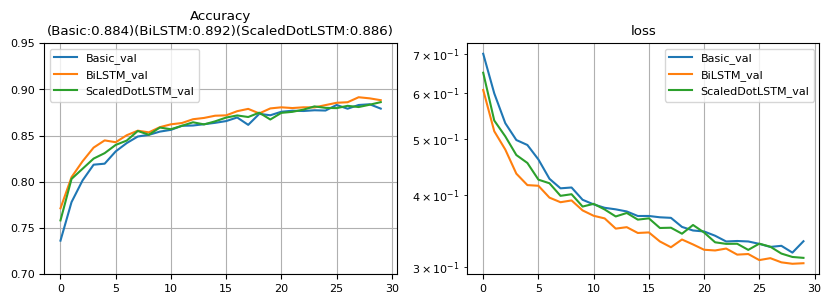

In [22]:
titles=["Basic","BiLSTM","ScaledDotLSTM"]
plt_history([history_1.history,history_2.history,history_3_3.history],titles,0.7)

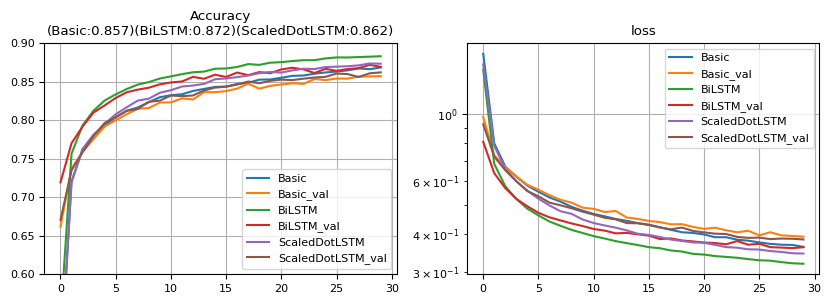

## Model-3.4 Self Attention  
### 1) ScaledDotProductAttn.에 key 입력 추가
### 2) q,k,v : linear projection 사용   
### 3) Wv : 적절히 조절 필요

In [23]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def call(self, query, key, value): # key 추가
        # query, key, value: (bs, time_steps, hidden_dim)
        d_k = tf.cast(tf.shape(key)[-1], tf.float32)  # hidden_dim
        # score: (bs, time_steps, time_steps)
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(d_k)
        # attention weights: (bs, time_steps, time_steps)
        attention_weights = tf.nn.softmax(score, axis=-1)
        # context vector: (bs, time_steps, hidden_dim)
        context_vector = tf.matmul(attention_weights, value)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    # LSTM 블록
    for _ in range(num_layers):
        x = layers.Bidirectional(
              layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    # Self-Attention: Q=K=V = x
    # q, k, v projection
    q = layers.Dense(lstm_units)(x)  # (bs, time_steps, d_k)
    k = layers.Dense(lstm_units)(x)
    v = layers.Dense(lstm_units//2)(x)
    attention_layer = ScaledDotProductAttention()
    context_vector, attn_weights = attention_layer(q, k, v)  # Q, K, V 모두 LSTM 출력

    # Context vector를 global 평균 pooling 후 classification
    # context vector가 time_step을 가지므로 후처리가 추가됨
    # 후처리를 어떻게 하는가에 따라 성능 차이가 발생함
    x = layers.GlobalAveragePooling1D()(context_vector)  # (bs, hidden_dim)
    x = layers.Dropout(0.)(x)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 28, 14)         │            406 │ input_layer_3[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 28, 256)        │        146,432 │ time_distributed_3[0]… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 28, 128)        │         32,896 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 28, 128)        │         32,896 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 28, 64)         │         16,448 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ [(None, 28, 64),       │              0 │ dense_7[0][0],         │
│ (ScaledDotProductAttenti… │ (None, 28, 28)]        │                │ dense_8[0][0],         │
│                           │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ scaled_dot_product_at… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 10)             │            650 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 229,728 (897.38 KB)

 Trainable params: 229,728 (897.38 KB)

 Non-trainable params: 0 (0.00 B)

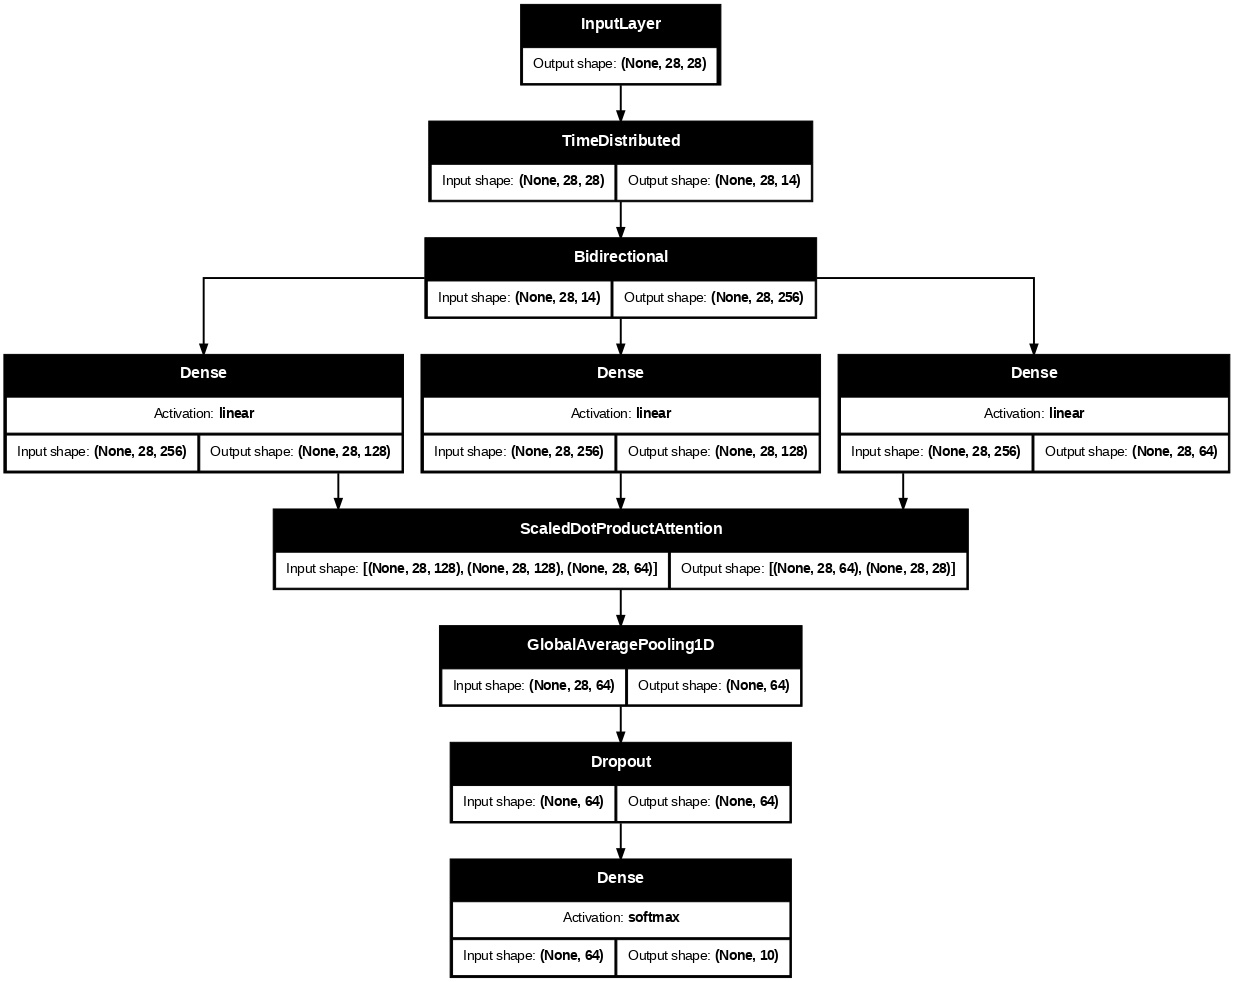

In [24]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [26]:
%%time
batch_size = 512
history_3_4 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 0.5232 - loss: 1.3326 - val_acc: 0.7448 - val_loss: 0.6608
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.7791 - loss: 0.5911 - val_acc: 0.7864 - val_loss: 0.5728
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8090 - loss: 0.5124 - val_acc: 0.8099 - val_loss: 0.5042
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8247 - loss: 0.4685 - val_acc: 0.8135 - val_loss: 0.4805
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8398 - loss: 0.4329 - val_acc: 0.8213 - val_loss: 0.4787
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8439 - loss: 0.4165 - val_acc: 0.8401 - val_loss: 0.4237
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8532 - loss: 0.3978 - val_acc: 0.8551 - val_loss: 0.3980
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8604 - loss: 0.3754 - val_acc: 0.8469 - val_loss: 0.4094
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/

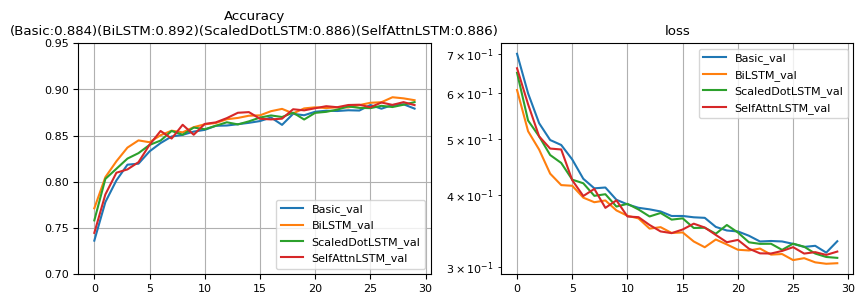

In [27]:
titles=["Basic","BiLSTM","ScaledDotLSTM","SelfAttnLSTM"]
plt_history([history_1.history,history_2.history,history_3_3.history,history_3_4.history],titles,0.7)

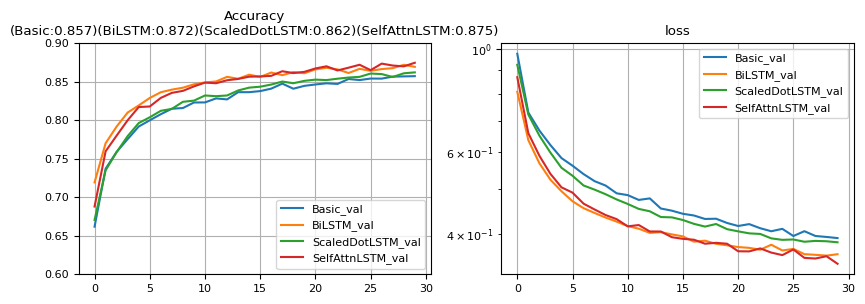

## Model-3.5 Multi-Head Attention

In [28]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, dim, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.dim = dim
        self.depth = dim // num_heads  # per-head dimension

        # Q, K, V projection
        self.Wq = layers.Dense(dim)
        self.Wk = layers.Dense(dim)
        self.Wv = layers.Dense(dim)

        # Output projection
        self.dense = layers.Dense(dim)

    def split_heads(self, x, batch_size):
        # x: (bs, time, dim) → (bs, num_heads, time, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):  # Self-Attention: Q=K=V=x
        batch_size = tf.shape(x)[0]

        q = self.Wq(x)  # (bs, time, dim)
        k = self.Wk(x)
        v = self.Wv(x)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled Dot-Product Attention
        d_k = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)  # (bs, heads, time, time)
        attn_weights = tf.nn.softmax(scores, axis=-1)  # (bs, heads, time, time)
        context = tf.matmul(attn_weights, v)  # (bs, heads, time, depth)

        # Head concat
        context = tf.transpose(context, perm=[0, 2, 1, 3])  # (bs, time, heads, depth)
        context = tf.reshape(context, (batch_size, -1, self.dim))  # (bs, time, dim)

        # Final projection
        output = self.dense(context)  # (bs, time, dim)
        return output, attn_weights

In [29]:
def Attention_LSTM_Model_MHA(hidden_size, num_layers, num_heads):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers):
        x = layers.Bidirectional(
              layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    # Multi-Head Self-Attention
    attn_layer = MultiHeadSelfAttention(num_heads=num_heads, dim=hidden_size)
    attn_output, attn_weights = attn_layer(x)  # (bs, time, hidden_size)

    # Attention output pooling
    x = layers.GlobalAveragePooling1D()(attn_output)  # (bs, hidden_size)

    # Output
    x = layers.Dropout(0.)(x)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_LSTM_Model_MHA( hidden_size=lstm_units, num_layers=1, num_heads=16)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 28, 14)              │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 28, 256)             │         146,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_self_attention            │ [(None, None, 128), (None,  │         115,200 │
│ (MultiHeadSelfAttention)             │ 16, None, None)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,328 (1.00 MB)

 Trainable params: 263,328 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

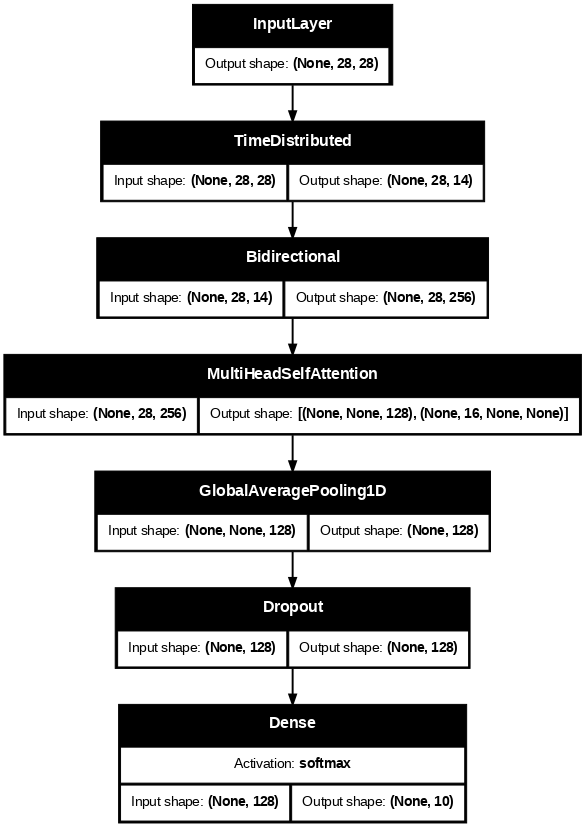

In [30]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [32]:
%%time
batch_size = 512
history_3_5 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - acc: 0.5237 - loss: 1.2844 - val_acc: 0.7416 - val_loss: 0.6685
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.7743 - loss: 0.6049 - val_acc: 0.7896 - val_loss: 0.5616
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.8153 - loss: 0.4973 - val_acc: 0.8174 - val_loss: 0.4886
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.8277 - loss: 0.4590 - val_acc: 0.8323 - val_loss: 0.4554
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8418 - loss: 0.4259 - val_acc: 0.8420 - val_loss: 0.4245
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.8518 - loss: 0.4025 - val_acc: 0.8497 - val_loss: 0.4086
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8609 - loss: 0.3750 - val_acc: 0.8518 - val_loss: 0.3916
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.8636 - loss: 0.3649 - val_acc: 0.8488 - val_loss: 0.4086
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/

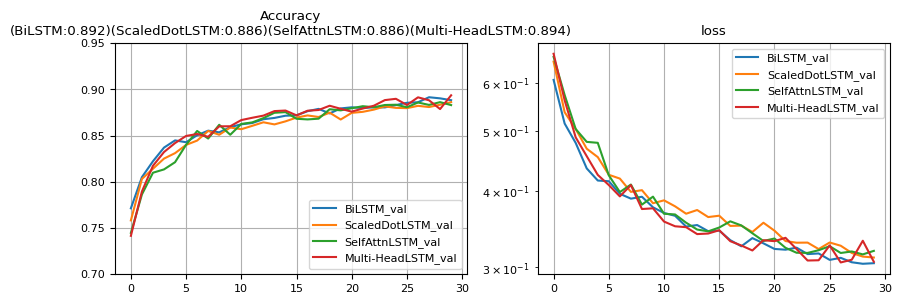

In [33]:
titles=["BiLSTM","ScaledDotLSTM","SelfAttnLSTM","Multi-HeadLSTM"]
plt_history([history_2.history,history_3_3.history,history_3_4.history,history_3_5.history],titles,0.7)

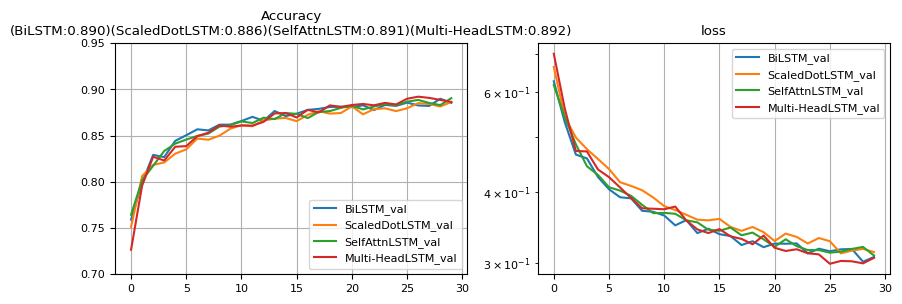

# 실습과제 1 : Multi-Block Multi-Head Attention  
## 225page의 구조를 넣어서 모델을 수정해 보자    
## 5epoch만 학습해 보자(성능보다 구조 만들기가 목표)


## Model-3.6 Muli-Block Multi-Head Attention

In [34]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, dim, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.dim = dim
        self.depth = dim // num_heads  # per-head dimension

        # Q, K, V projection
        self.Wq = layers.Dense(dim)
        self.Wk = layers.Dense(dim)
        self.Wv = layers.Dense(dim)

        # Output projection
        self.dense = layers.Dense(dim)

    def split_heads(self, x, batch_size):
        # x: (bs, time, dim) → (bs, num_heads, time, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):  # Self-Attention: Q=K=V=x
        batch_size = tf.shape(x)[0]

        q = self.Wq(x)  # (bs, time, dim)
        k = self.Wk(x)
        v = self.Wv(x)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled Dot-Product Attention
        d_k = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)  # (bs, heads, time, time)
        attn_weights = tf.nn.softmax(scores, axis=-1)  # (bs, heads, time, time)
        context = tf.matmul(attn_weights, v)  # (bs, heads, time, depth)

        # Head concat
        context = tf.transpose(context, perm=[0, 2, 1, 3])  # (bs, time, heads, depth)
        context = tf.reshape(context, (batch_size, -1, self.dim))  # (bs, time, dim)

        # Final projection
        output = self.dense(context)  # (bs, time, dim)
        return output, attn_weights

In [35]:
class FeedForward(layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.ff = keras.Sequential([
      layers.Dense(dff,'gelu'),#(bs,seq,diff)
      layers.Dropout(0.1),
      layers.Dense(d_model),   #(bs,seq,d)
      # layers.Dropout(0.1),
    ])
  def call(self, x):   #(bs, seq_len, d)
    return self.ff(x)  #(bs, seq_len, d)

In [36]:
def Attention_LSTM_Model_MHA(hidden_size, num_layers, num_heads):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers):
        x = layers.Bidirectional(
              layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    # Multi-Head Self-Attention
    x_A, _ = MultiHeadSelfAttention(num_heads=num_heads, dim=hidden_size*2)(x)
    x = layers.LayerNormalization()(x + x_A)
    x = layers.LayerNormalization()(FeedForward(hidden_size*2, hidden_size*4)(x) + x)

    x_A, _ = MultiHeadSelfAttention(num_heads=num_heads, dim=hidden_size*2)(x)
    x = layers.LayerNormalization()(x + x_A)
    x = layers.LayerNormalization()(FeedForward(hidden_size*2, hidden_size*4)(x) + x)

    x_A, _ = MultiHeadSelfAttention(num_heads=num_heads, dim=hidden_size*2)(x)
    x = layers.LayerNormalization()(x + x_A)
    x = layers.LayerNormalization()(FeedForward(hidden_size*2, hidden_size*4)(x) + x)

    # Attention output pooling
    x = layers.GlobalAveragePooling1D()(x)  # (bs, hidden_size)

    # Output
    x = layers.Dropout(0.)(x)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_LSTM_Model_MHA( hidden_size=lstm_units, num_layers=1, num_heads=16)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 28, 14)         │            406 │ input_layer_5[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 28, 256)        │        146,432 │ time_distributed_5[0]… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_self_attentio… │ [(None, None, 256),    │        263,168 │ bidirectional_4[0][0]  │
│ (MultiHeadSelfAttention)  │ (None, 16, None,       │                │                        │
│                           │ None)]                 │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 256)        │              0 │ bidirectional_4[0][0], │
│                           │                        │                │ multi_head_self_atten… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 28, 256)        │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feed_forward              │ (None, 28, 256)        │        262,912 │ layer_normalization[0… │
│ (FeedForward)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 28, 256)        │              0 │ feed_forward[0][0],    │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 28, 256)        │            512 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_self_attentio… │ [(None, None, 256),    │        263,168 │ layer_normalization_1… │
│ (MultiHeadSelfAttention)  │ (None, 16, None,       │                │                        │
│                           │ None)]                 │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 28, 256)        │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_self_atten… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 28, 256)        │            512 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feed_forward_1       

 Total params: 1,730,720 (6.60 MB)

 Trainable params: 1,730,720 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

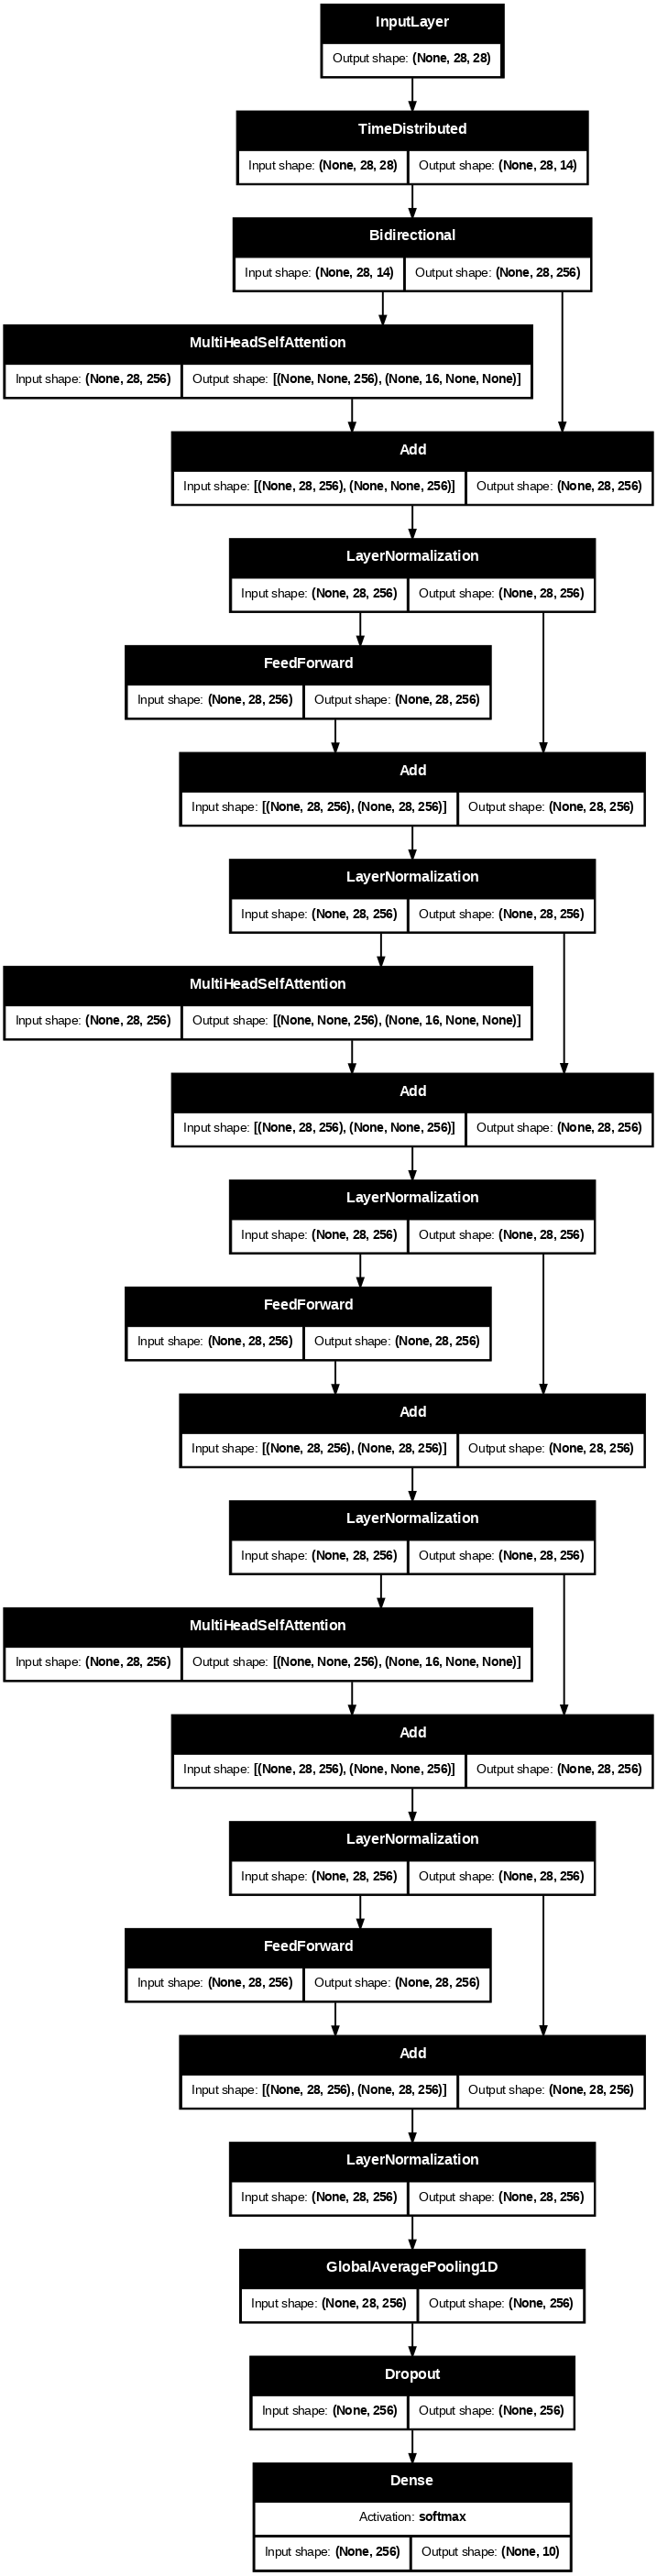

In [37]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [38]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [39]:
%%time
batch_size = 512
history_3_6 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - acc: 0.5049 - loss: 1.5316 - val_acc: 0.7905 - val_loss: 0.5619
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.8070 - loss: 0.5163 - val_acc: 0.8255 - val_loss: 0.4592
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.8440 - loss: 0.4152 - val_acc: 0.8445 - val_loss: 0.4109
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.8642 - loss: 0.3647 - val_acc: 0.8633 - val_loss: 0.3880
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.8733 - loss: 0.3363 - val_acc: 0.8605 - val_loss: 0.3748
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - acc: 0.8795 - loss: 0.3218 - val_acc: 0.8679 - val_loss: 0.3533
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - acc: 0.8869 - loss: 0.3011 - val_acc: 0.8812 - val_loss: 0.3280
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - acc: 0.8942 - loss: 0.2814 - val_acc: 0.8780 - val_loss: 0.3212
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 

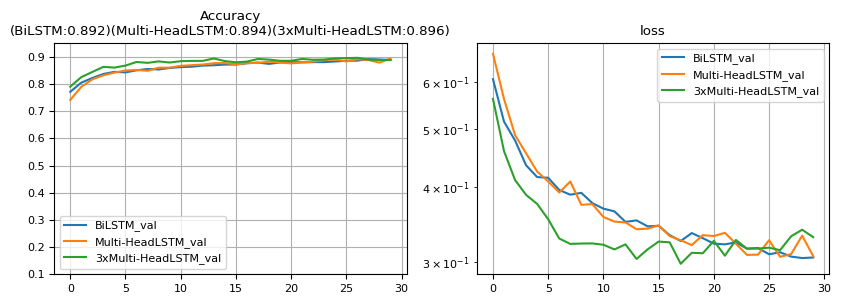

In [40]:
titles=["BiLSTM","Multi-HeadLSTM","3xMulti-HeadLSTM"]
plt_history([history_2.history,history_3_5.history,history_3_6.history],titles,0.1)

# 실습과제 2 : Conv1D + Self Attention 구조 만들기  

### **Import Module**

In [41]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

keras.__version__

'3.8.0'

In [42]:
# FashionMNIST 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)

print(f"Original shape: {x_train.shape}")
ps(x_test[0:3]), ps(y_test[0:3])


Original shape: (60000, 28, 28)
<<>> Shape(3, 28, 28)
<<>> Shape(3,)


(None, None)

### Kernel size : 3

In [43]:
### **Model-1** : 1D CNN Model
# 주요 변수 정의
kernel_size = 3        # 1D conv kernel size
pool_size = 2          # pooling size
dense_units = 128      # dense layer units
out_dense = 10         # 출력은 숫자(0~9) 확률

## Model-1 설계 : 1D CNN 모델
def model_1(kernel_size=3):
    return keras.models.Sequential([
          keras.Input(shape=(28,28)),
          layers.TimeDistributed(                   #(bs,28,64)
              layers.Dense(64, activation='relu'), name='in_dense'),
          # 첫 번째 1D Conv 블록                      (bs,28,64)
          layers.Conv1D(64, kernel_size=kernel_size, padding='same'),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.MaxPooling1D(pool_size=pool_size), #(bs,14,64)
          # 두 번째 1D Conv 블록                      (bs,14,128)
          layers.Conv1D(128, kernel_size=kernel_size, padding='same'),
          layers.ReLU(),
          layers.MaxPooling1D(pool_size=pool_size), #(bs,7,128)
          # Global Average Pooling으로 차원 축소
          layers.GlobalAveragePooling1D(),          #(bs,128)
          # Dense layers
          layers.Dense(dense_units, activation='relu'),
          layers.Dense(out_dense, activation='softmax')
    ], name="1D-CNN")

model = model_1(3)  # Model Instance
model.summary()

Model: "1D-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_dense (TimeDistributed)           │ (None, 28, 64)              │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 28, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,970 (222.54 KB)

 Trainable params: 56,842 (222.04 KB)

 Non-trainable params: 128 (512.00 B)

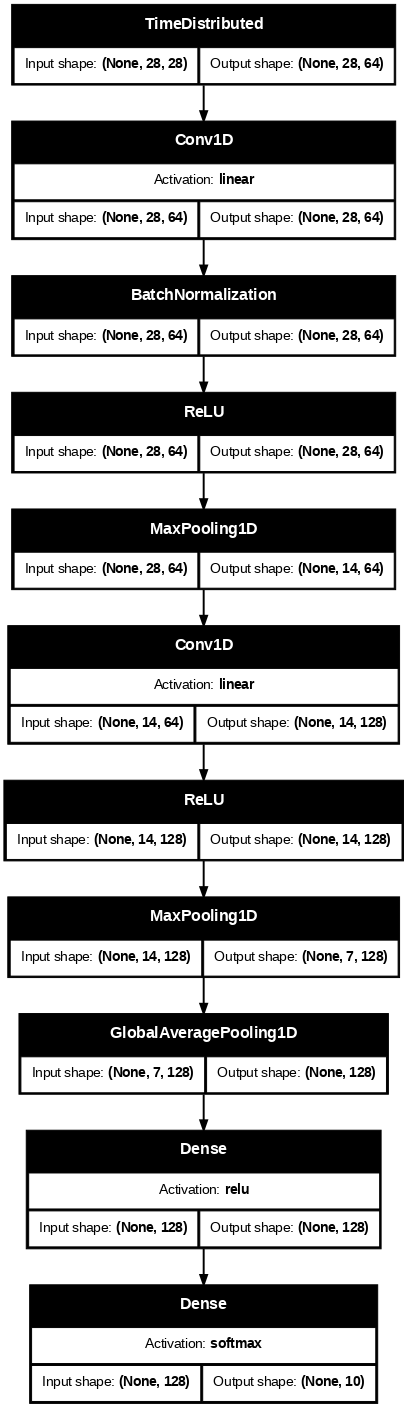

In [44]:
# 모델 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=70)

In [45]:
%%time
kernel_size=3
model = model_1(kernel_size)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 512
history_1 = model.fit(x_train, y_train,  # 1D 형태의 데이터 사용
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)
# Wall time: 52.8 s

Model: "1D-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_dense (TimeDistributed)           │ (None, 28, 64)              │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 28, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 14, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,970 (222.54 KB)

 Trainable params: 56,842 (222.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.5976 - loss: 1.2047 - val_accuracy: 0.7556 - val_loss: 1.1342
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8254 - loss: 0.4904 - val_accuracy: 0.8327 - val_loss: 0.6673
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8564 - loss: 0.4063 - val_accuracy: 0.8463 - val_loss: 0.4761
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8685 - loss: 0.3686 - val_accuracy: 0.8627 - val_loss: 0.3951
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8754 - loss: 0.3390 - val_accuracy: 0.8440 - val_loss: 0.4377
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8794 - loss: 0.3275 - val_accuracy: 0.8735 - val_loss: 0.3490
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8902 - loss: 0.3052 - val_accuracy: 0.8530 - val_loss: 0.3985
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8940 - loss: 0.2922 - val_accuracy:

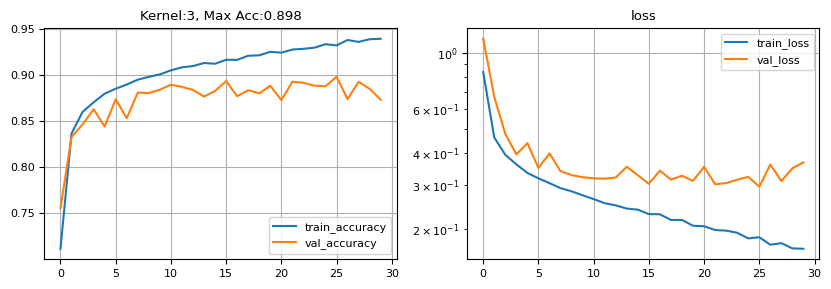

In [46]:
history = history_1.history

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title(f"Kernel:{kernel_size}, Max Acc:{np.max(history['val_accuracy']):.3f}")
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("loss")
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

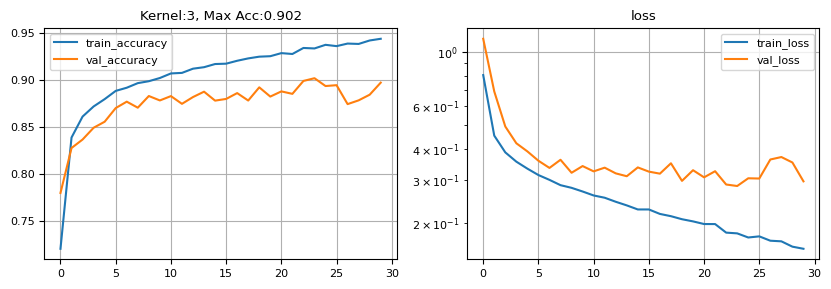

## Hierarchical 1d-CNN Mnist  
* 1단계: TimeDistributed + Conv1D로 각 행(28픽셀)을 개별 스캔  
* 2단계: 행별 특성들을 수직방향으로 Conv1D 스캔  
* 3단계: GlobalPooling으로 최종 특성 추출 후 분류  

In [47]:
# FMNIST 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)
x_train = x_train.reshape(-1, 28, 28, 1)  # (60000, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Data shape: {x_train.shape}")
ps(x_test[0:3]), ps(y_test[0:3])

Data shape: (60000, 28, 28, 1)
<<>> Shape(3, 28, 28, 1)
<<>> Shape(3,)


(None, None)

In [48]:
### **Hierarchical CNN Model** : Line-by-Line Scanning
# 1단계: 각 line을 1D Conv로 수평방향 스캔
# 2단계: 행들의 특성을 수직방향 스캔
def hierarchical_cnn_model():
    input_layer = keras.Input(shape=(28, 28, 1), name='input_image')
    # 전처리
    x = layers.BatchNormalization()(input_layer)
    x = layers.ReLU()(x)
    # 1단계: 각 행을 개별적으로 1D Conv로 처리
    x = layers.TimeDistributed(           #(bs,28,28,16)
          layers.Conv1D(32, 5, activation='relu', padding='same'), name='line_conv1d')(x)
    # AdaptiveAveragePooling1D 시뮬레이션 (28→14로 절반만 축소)
    x = layers.TimeDistributed(           #(bs,28,14,16)
        layers.AveragePooling1D(pool_size=2, strides=2))(x)
    # 추가 Conv로 더 정교한 특성 추출
    x = layers.TimeDistributed(           #(bs,28,14,32)
        layers.Conv1D(64, 3, activation='relu', padding='same') )(x)
    # 더 적극적으로 압축
    x = layers.TimeDistributed(           #(bs,28,32)
        layers.GlobalAveragePooling1D())(x)
    # 2단계: 행들 간의 관계를 스캔 (수직 방향) (bs,28,128)
    x = layers.Conv1D(128, 3, activation='relu', padding='same', name='vertical_conv1d' )(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same', name='vertical_conv1d_2')(x)
    # 최종 특성 추출                        (bs,128)
    x = layers.GlobalAveragePooling1D(name='global_pooling')(x)
    # 분류
    x = layers.Dense(64, activation='relu', name='dense')(x)
    output_layer = layers.Dense(10, activation='softmax', name='output')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer, name='Hierarchical_Line_CNN')
    return model

    # 모델 생성 및 요약
model = hierarchical_cnn_model()
model.summary()

Model: "Hierarchical_Line_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ line_conv1d (TimeDistributed)        │ (None, 28, 28, 32)          │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 28, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 28, 14, 64)          │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vertical_conv1d (Conv1D)             │ (None, 28, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vertical_conv1d_2 (Conv1D)           │ (None, 28, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_pooling                       │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,294 (348.80 KB)

 Trainable params: 89,292 (348.80 KB)

 Non-trainable params: 2 (8.00 B)

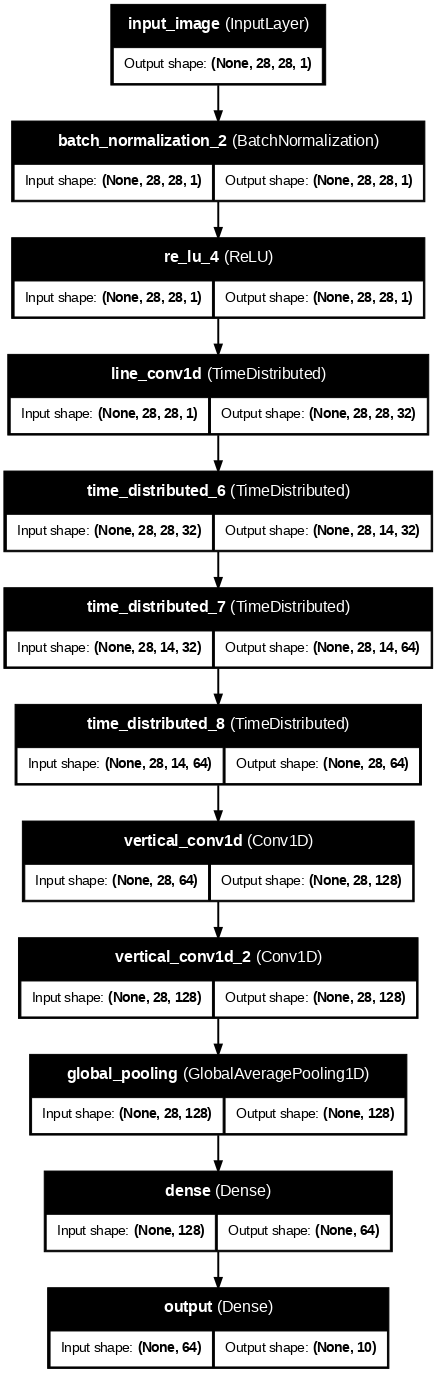

In [49]:
# 모델 구조 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

In [50]:
%%time
model = hierarchical_cnn_model()
#### 모델 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 512
history_hierarchical = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30,
          verbose=1)
# Wall time: 1min 54s

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.2531 - loss: 2.0054 - val_accuracy: 0.5294 - val_loss: 1.2356
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5712 - loss: 1.1534 - val_accuracy: 0.6003 - val_loss: 1.0444
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6545 - loss: 0.9380 - val_accuracy: 0.6673 - val_loss: 0.8881
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6986 - loss: 0.8165 - val_accuracy: 0.7217 - val_loss: 0.7627
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7355 - loss: 0.7396 - val_accuracy: 0.7530 - val_loss: 0.7110
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7558 - loss: 0.6776 - val_accuracy: 0.7678 - val_loss: 0.6587
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7704 - loss: 0.6418 - val_accuracy: 0.7752 - val_loss: 0.6170
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7856 - loss: 0.6024 - val_ac

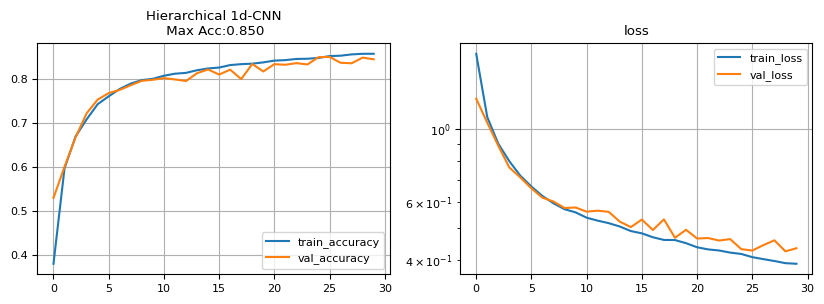

In [51]:
#### 결과 시각화
history = history_hierarchical.history

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title(f"Hierarchical 1d-CNN\n Max Acc:{np.max(history['val_accuracy']):.3f}")
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("loss")
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

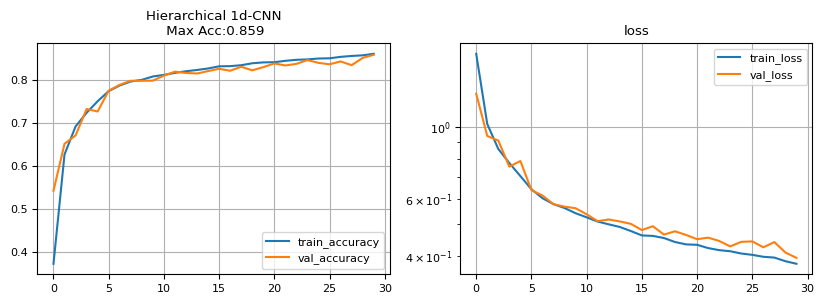

# 실습과제 3 : Permutation MNIST
## Attention의 역할을 더 돋보이도록 하기 위해서 line의 순서를 썩은 dataset를 준비하자  
## Model-2, Model-3.5, 실습과제 2에서 제시된 Conv1D을 사용한 모델을 학습시켜,  차이가 보이는지 확인 하자

#### Load

In [52]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)

In [53]:
# 28개의 row index를 무작위로 섞는다
permuted_indices = np.random.permutation(28)

# row 순서를 permute
x_train_shuffled = x_train[:, permuted_indices, :]
x_test_shuffled = x_test[:, permuted_indices, :]

In [54]:
ps(x_train_shuffled);ps(y_train)
ps(x_test_shuffled);ps(y_test)

<<>> Shape(60000, 28, 28)
<<>> Shape(60000,)
<<>> Shape(10000, 28, 28)
<<>> Shape(10000,)


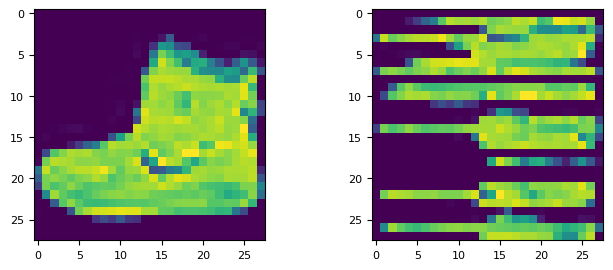

In [55]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(x_train[0])
plt.subplot(122)
plt.imshow(x_train_shuffled[0])
plt.show()

In [56]:
# x_train = x_train_shuffled
# x_test = x_test_shuffled

### Patching & shuffling  
> (28, 28) 이미지를 7x7 패치 단위 (patch_size=4)로 나누어 49개 패치로 만들고  
> 각 패치를 벡터로 펼친 뒤 시퀀스로 구성 (49, patch_dim)  
> 순서를 random.shuffle()로 무작위화

In [57]:
import numpy as np

def shuffle_image_patches(image, patch_size=4, seed=None):
    """
    단일 이미지 (28x28)를 패치 단위로 나누고 순서를 섞은 후 다시 (28x28)로 재배치
    image: (28, 28) numpy array
    return: (28, 28) numpy array (patch 순서가 랜덤하게 섞인 이미지)
    """
    h, w = image.shape
    assert h % patch_size == 0 and w % patch_size == 0, "패치 크기로 나눌 수 있어야 함"

    num_patches_h = h // patch_size  # 예: 7
    num_patches_w = w // patch_size  # 예: 7
    num_patches = num_patches_h * num_patches_w

    patches = []

    # 1. 패치 분할
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch = image[
                i*patch_size:(i+1)*patch_size,
                j*patch_size:(j+1)*patch_size
            ]
            patches.append(patch)

    # 2. 순서 섞기
    if seed is not None:
        rng = np.random.RandomState(seed)
        rng.shuffle(patches)
    else:
        np.random.shuffle(patches)

    # 3. 패치 재배치
    new_image = np.zeros_like(image)
    for idx, patch in enumerate(patches):
        i = idx // num_patches_w
        j = idx % num_patches_w
        new_image[
            i*patch_size:(i+1)*patch_size,
            j*patch_size:(j+1)*patch_size
        ] = patch

    return new_image



In [58]:
# 패치 시퀀스로 변환
# train 전체에 적용
x_train_shuffled = np.array([shuffle_image_patches(img, patch_size=4) for img in x_train])
x_test_shuffled = np.array([shuffle_image_patches(img, patch_size=4) for img in x_test])

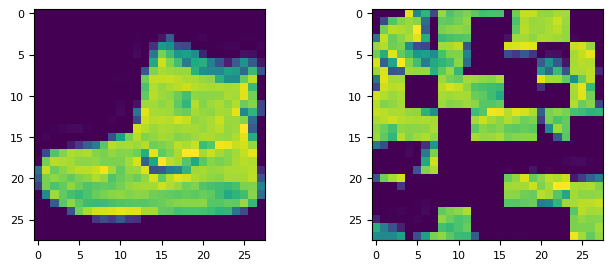

In [59]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(x_train[0])
plt.subplot(122)
plt.imshow(x_train_shuffled[0])
plt.show()

In [60]:
x_train = x_train_shuffled
x_test = x_test_shuffled

## Plot history

In [61]:
def plt_history(historys,names,min_acc=0.6):
    mins =[]
    title_name = ""
    for i,h in enumerate(historys):
        title_name += f"({names[i]}:{max(h['val_acc']):.3f})"
    plt.figure(figsize=(10,3))
    plt.subplot(121)

    for i,h in enumerate(historys):
#        plt.plot(h['acc'], label=names[i])
        plt.plot(h['val_acc'], label=names[i]+"_val")
    plt.title("Accuracy\n"+title_name)
    plt.ylim(min_acc, 0.95)
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.title("loss")
    for i,h in enumerate(historys):
#        plt.plot(h['loss'], label=names[i])
        plt.plot(h['val_loss'], label=names[i]+"_val")
    #plt.ylim(0.1, 1)
    plt.semilogy()
    plt.legend()
    plt.grid()

    plt.show()

In [62]:
lstm_units = 128 # 32에서 128로 증가 시킴

In [63]:
# 주요 변수 정의
features = 28   #pixels
time_steps = 28 #lines
in_dense = 14   # 임의 값
out_dense = 10  # 출력은 숫자(0~9) 확률

## **Model-1** : Basic LSTM Model

Model: "Basic-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_12                  │ (None, 28, 14)              │             406 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │          73,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,912 (292.62 KB)

 Trainable params: 74,912 (292.62 KB)

 Non-trainable params: 0 (0.00 B)

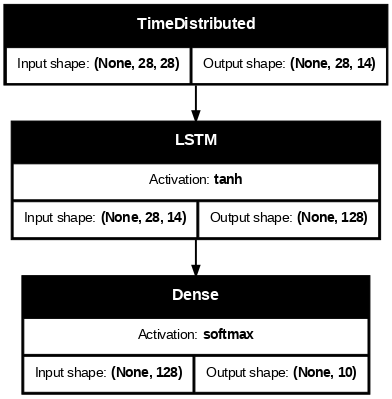

In [64]:
## Model-1 설계 : many to one 기본 모델
def model_1():
    return keras.models.Sequential([
          keras.Input(shape=(time_steps, features)),
          layers.TimeDistributed(layers.Dense(in_dense)),
          layers.LSTM(lstm_units,dropout=0.1),         # LSTM
          layers.Dense(out_dense, activation='softmax')
    ],name="Basic-RNN")

model = model_1() # Model Instance

model.summary()
keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [65]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [66]:
%%time
batch_size = 512
history_1 = model.fit(x_train, y_train,   #(60000,28,28),(60000,)
          validation_data=(x_test, y_test), #(10000,28,28),(10000,)
          batch_size=batch_size,
          epochs=30)
# Wall time: 31.5 s

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.1670 - loss: 2.1517 - val_acc: 0.2735 - val_loss: 1.9174
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2902 - loss: 1.8538 - val_acc: 0.3412 - val_loss: 1.7219
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.3492 - loss: 1.6909 - val_acc: 0.3755 - val_loss: 1.6443
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.3748 - loss: 1.6347 - val_acc: 0.3989 - val_loss: 1.5782
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4013 - loss: 1.5718 - val_acc: 0.4138 - val_loss: 1.5536
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4199 - loss: 1.5315 - val_acc: 0.4220 - val_loss: 1.5264
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.4427 - loss: 1.4737 - val_acc: 0.4489 - val_loss: 1.4513
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.4540 - loss: 1.4391 - val_acc: 0.4566 - val_loss: 1.4278
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

Wall time: 22.6 s


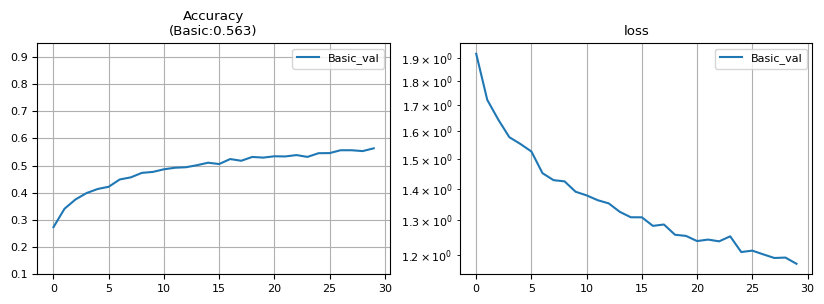

In [67]:
titles=["Basic"]
plt_history([history_1.history],titles,0.1)

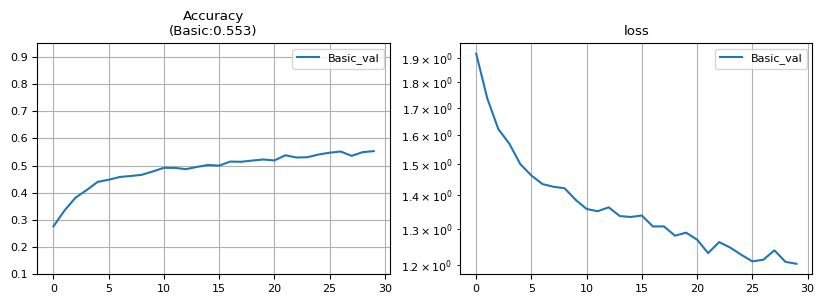

## **Model-2** : Bidirectional Model

Model: "Bidirectional-RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_13                  │ (None, 28, 14)              │             406 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 256)                 │         146,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,408 (583.62 KB)

 Trainable params: 149,408 (583.62 KB)

 Non-trainable params: 0 (0.00 B)

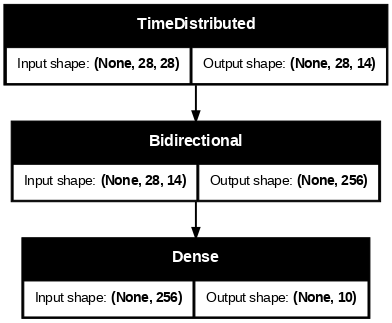

In [68]:
## Model-2 설계 : Bidirectional 추가
def model_2():
    model = keras.models.Sequential(name="Bidirectional-RNN")
    model.add(keras.Input(shape=(time_steps, features)))
    model.add(layers.TimeDistributed(layers.Dense(in_dense)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units,dropout=0.1)))
    model.add(layers.Dense(out_dense, activation='softmax'))
    return model

model = model_2()
model.summary()
keras.utils.plot_model(model,'model.png',show_shapes=True,dpi=70)


In [69]:
# model_Bi : bi-RNN
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#### Fit

In [ ]:
%%time
batch_size = 512
history_2 = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.1814 - loss: 2.1214 - val_acc: 0.2984 - val_loss: 1.8251
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3240 - loss: 1.7612 - val_acc: 0.3597 - val_loss: 1.6518
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3737 - loss: 1.6293 - val_acc: 0.3997 - val_loss: 1.5751
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4100 - loss: 1.5476 - val_acc: 0.4263 - val_loss: 1.5014
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4385 - loss: 1.4768 - val_acc: 0.4627 - val_loss: 1.4453
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4558 - loss: 1.4366 - val_acc: 0.4665 - val_loss: 1.4113
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4734 - loss: 1.3905 - val_acc: 0.4793 - val_loss: 1.3925
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4873 - loss: 1.3639 - val_acc: 0.4800 - val_loss: 1.3771
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

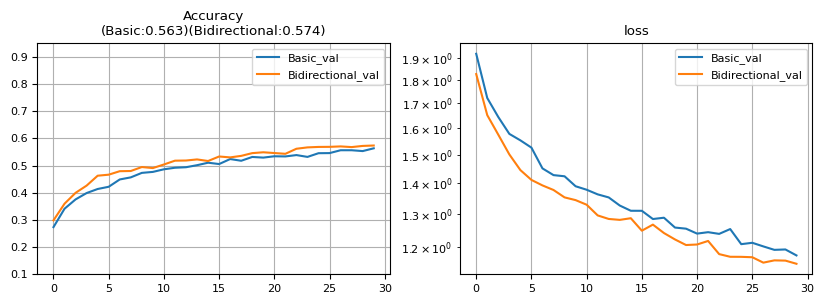

In [ ]:
titles=["Basic","Bidirectional"]
plt_history([history_1.history,history_2.history],titles,0.1)

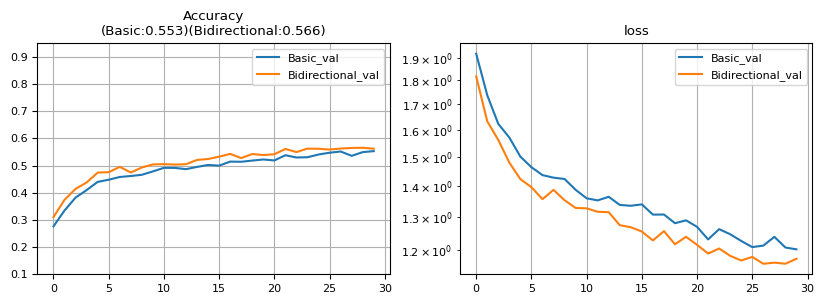

## Model-3.3 Scaled Dot-Product Attention  
### query로 부터 key를

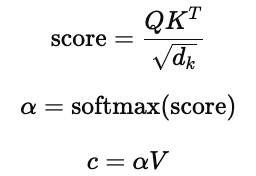

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
    # query: (batch_size, hidden_dim), values: (batch_size, time_steps, hidden_dim)
    def call(self, query, values):
        d_k = tf.cast(tf.shape(query)[-1], tf.float32)
        query_expanded = tf.expand_dims(query, axis=1)      #(bs, 1, hidden_dim)
        # (bs, 1, hidden_dim) · (bs, time_steps, hidden_dim)^T → (bs, 1, time_steps)
        score = tf.matmul(query_expanded, values, transpose_b=True) / tf.math.sqrt(d_k)
        attention_weights = tf.nn.softmax(score, axis=-1)    # (bs, 1, time_steps)
        context_vector = tf.matmul(attention_weights, values)# (bs, 1, hidden_dim)
        context_vector = tf.squeeze(context_vector, axis=1)  #(bs, hidden_dim)
        return context_vector, attention_weights

In [ ]:
## LSTM 마지막 상태를 Query로 사용
def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers): # x:(bs, time_steps, hidden_size)
        x = layers.Bidirectional(
            layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    query = layers.Lambda(lambda t: t[:, -1, :])(x) # 마지막 time_steps을 query로 사용

    # Attention 적용
    attention_layer = ScaledDotProductAttention()
    context_vector, attn_weights = attention_layer(query, x) # (Q,V(K))

    x = layers.Dropout(0.)(context_vector)
    outputs = layers.Dense(out_dense, activation='softmax')(x)
    model = keras.Model(inputs=in_layer, outputs=[outputs])
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_14       │ (None, 28, 14)         │            406 │ input_layer_13[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 28, 256)        │        146,432 │ time_distributed_14[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 256)            │              0 │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ [(None, 256), (None,   │              0 │ lambda_1[0][0],        │
│ (ScaledDotProductAttenti… │ 1, 28)]                │                │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256)            │              0 │ scaled_dot_product_at… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 10)             │          2,570 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 149,408 (583.62 KB)

 Trainable params: 149,408 (583.62 KB)

 Non-trainable params: 0 (0.00 B)

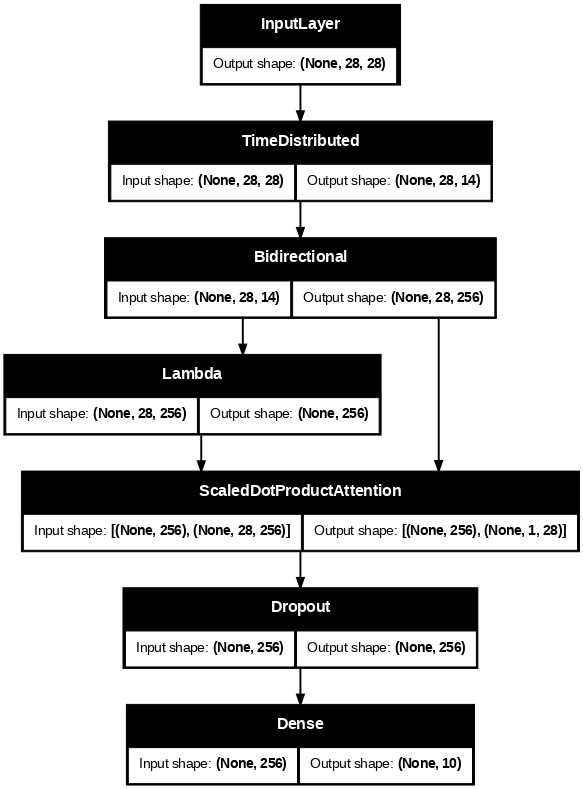

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=70)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [ ]:
%%time
batch_size = 512
history_3_3 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.1712 - loss: 2.1362 - val_acc: 0.2877 - val_loss: 1.8469
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3089 - loss: 1.7898 - val_acc: 0.3410 - val_loss: 1.7100
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.3557 - loss: 1.6702 - val_acc: 0.3885 - val_loss: 1.6122
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3955 - loss: 1.5813 - val_acc: 0.4072 - val_loss: 1.5393
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.4241 - loss: 1.5080 - val_acc: 0.4311 - val_loss: 1.4915
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.4458 - loss: 1.4610 - val_acc: 0.4329 - val_loss: 1.4740
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.4571 - loss: 1.4299 - val_acc: 0.4609 - val_loss: 1.4245
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.4803 - loss: 1.3859 - val_acc: 0.4731 - val_loss: 1.3946
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

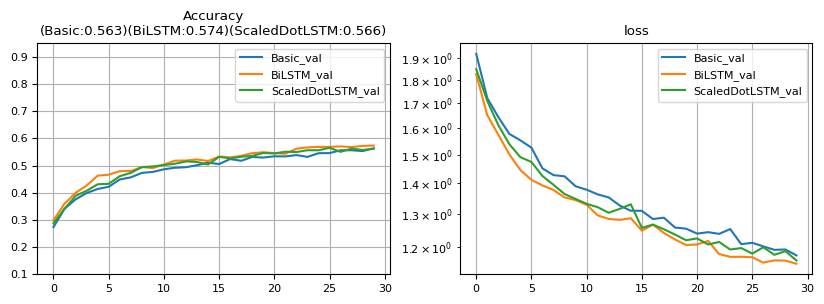

In [ ]:
titles=["Basic","BiLSTM","ScaledDotLSTM"]
plt_history([history_1.history,history_2.history,history_3_3.history],titles,0.1)

## Model-3.4 Self Attention  
### 1) ScaledDotProductAttn.에 key 입력 추가
### 2) q,k,v : linear projection 사용   
### 3) Wv : 적절히 조절 필요

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def call(self, query, key, value): # key 추가
        # query, key, value: (bs, time_steps, hidden_dim)
        d_k = tf.cast(tf.shape(key)[-1], tf.float32)  # hidden_dim
        # score: (bs, time_steps, time_steps)
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(d_k)
        # attention weights: (bs, time_steps, time_steps)
        attention_weights = tf.nn.softmax(score, axis=-1)
        # context vector: (bs, time_steps, hidden_dim)
        context_vector = tf.matmul(attention_weights, value)
        return context_vector, attention_weights

def Attention_lstm_model(hidden_size, num_layers):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    # LSTM 블록
    for _ in range(num_layers):
        x = layers.Bidirectional(
              layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    # Self-Attention: Q=K=V = x
    # q, k, v projection
    q = layers.Dense(lstm_units)(x)  # (bs, time_steps, d_k)
    k = layers.Dense(lstm_units)(x)
    v = layers.Dense(lstm_units//2)(x)
    attention_layer = ScaledDotProductAttention()
    context_vector, attn_weights = attention_layer(q, k, v)  # Q, K, V 모두 LSTM 출력

    # Context vector를 global 평균 pooling 후 classification
    # context vector가 time_step을 가지므로 후처리가 추가됨
    # 후처리를 어떻게 하는가에 따라 성능 차이가 발생함
    x = layers.GlobalAveragePooling1D()(context_vector)  # (bs, hidden_dim)
    x = layers.Dropout(0.)(x)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_lstm_model( hidden_size=lstm_units, num_layers=1)
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_15       │ (None, 28, 14)         │            406 │ input_layer_14[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 28, 256)        │        146,432 │ time_distributed_15[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 28, 128)        │         32,896 │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 28, 128)        │         32,896 │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 28, 64)         │         16,448 │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ scaled_dot_product_atten… │ [(None, 28, 64),       │              0 │ dense_50[0][0],        │
│ (ScaledDotProductAttenti… │ (None, 28, 28)]        │                │ dense_51[0][0],        │
│                           │                        │                │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ scaled_dot_product_at… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 10)             │            650 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 229,728 (897.38 KB)

 Trainable params: 229,728 (897.38 KB)

 Non-trainable params: 0 (0.00 B)

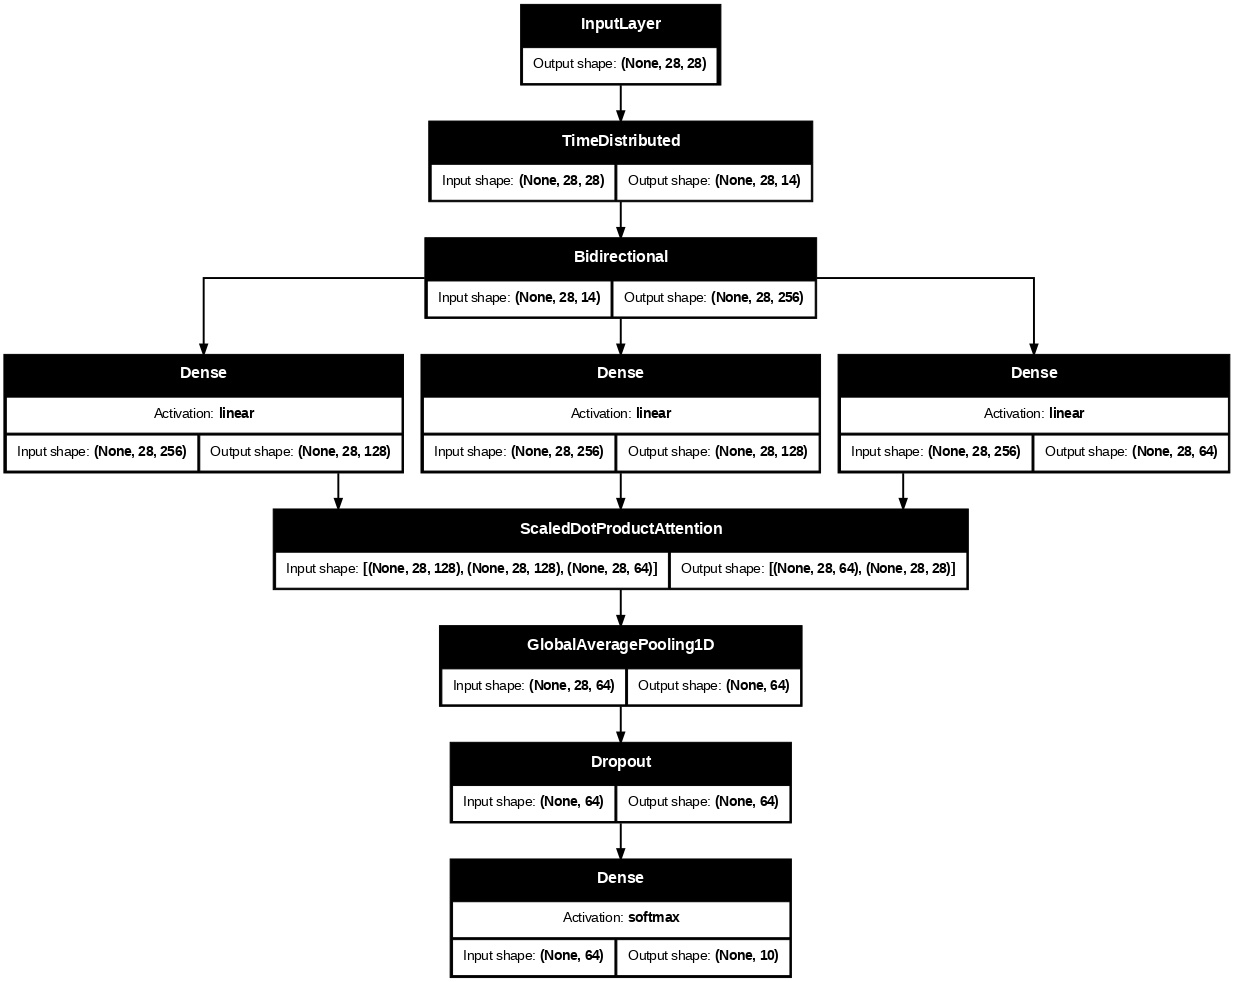

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [ ]:
%%time
batch_size = 512
history_3_4 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - acc: 0.1817 - loss: 2.1192 - val_acc: 0.3081 - val_loss: 1.8160
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.3298 - loss: 1.7557 - val_acc: 0.3673 - val_loss: 1.6744
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.3874 - loss: 1.6144 - val_acc: 0.4264 - val_loss: 1.5254
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.4313 - loss: 1.5103 - val_acc: 0.4494 - val_loss: 1.4670
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.4529 - loss: 1.4542 - val_acc: 0.4572 - val_loss: 1.4445
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.4649 - loss: 1.4170 - val_acc: 0.4765 - val_loss: 1.3948
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.4814 - loss: 1.3850 - val_acc: 0.4714 - val_loss: 1.4183
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.4783 - loss: 1.3789 - val_acc: 0.4815 - val_loss: 1.3737
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/

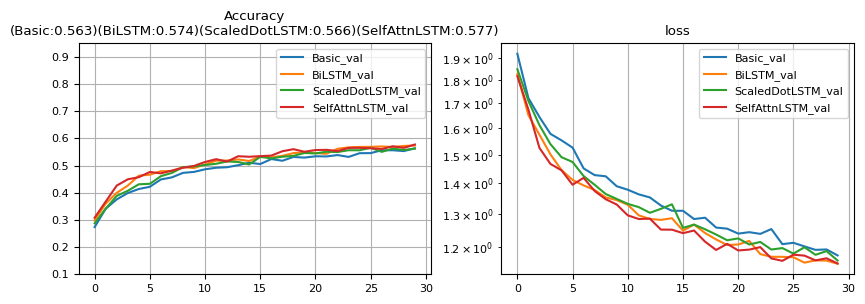

In [ ]:
titles=["Basic","BiLSTM","ScaledDotLSTM","SelfAttnLSTM"]
plt_history([history_1.history,history_2.history,history_3_3.history,history_3_4.history],titles,0.1)

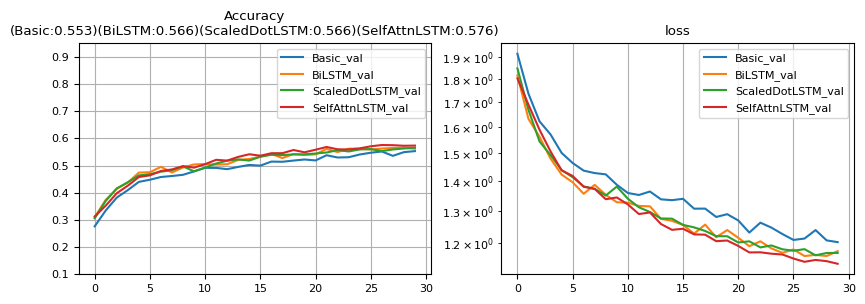

## Model-3.5 Multi-Head Attention

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, dim, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.dim = dim
        self.depth = dim // num_heads  # per-head dimension

        # Q, K, V projection
        self.Wq = layers.Dense(dim)
        self.Wk = layers.Dense(dim)
        self.Wv = layers.Dense(dim)

        # Output projection
        self.dense = layers.Dense(dim)

    def split_heads(self, x, batch_size):
        # x: (bs, time, dim) → (bs, num_heads, time, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):  # Self-Attention: Q=K=V=x
        batch_size = tf.shape(x)[0]

        q = self.Wq(x)  # (bs, time, dim)
        k = self.Wk(x)
        v = self.Wv(x)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled Dot-Product Attention
        d_k = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)  # (bs, heads, time, time)
        attn_weights = tf.nn.softmax(scores, axis=-1)  # (bs, heads, time, time)
        context = tf.matmul(attn_weights, v)  # (bs, heads, time, depth)

        # Head concat
        context = tf.transpose(context, perm=[0, 2, 1, 3])  # (bs, time, heads, depth)
        context = tf.reshape(context, (batch_size, -1, self.dim))  # (bs, time, dim)

        # Final projection
        output = self.dense(context)  # (bs, time, dim)
        return output, attn_weights

In [ ]:
def Attention_LSTM_Model_MHA(hidden_size, num_layers, num_heads):
    in_layer = keras.Input(shape=(time_steps, features))
    x = layers.TimeDistributed(layers.Dense(in_dense))(in_layer)

    for _ in range(num_layers):
        x = layers.Bidirectional(
              layers.LSTM(hidden_size, return_sequences=True, dropout=0.1))(x)

    # Multi-Head Self-Attention
    attn_layer = MultiHeadSelfAttention(num_heads=num_heads, dim=hidden_size)
    attn_output, attn_weights = attn_layer(x)  # (bs, time, hidden_size)

    # Attention output pooling
    x = layers.GlobalAveragePooling1D()(attn_output)  # (bs, hidden_size)

    # Output
    x = layers.Dropout(0.)(x)
    outputs = layers.Dense(out_dense, activation='softmax')(x)

    model = keras.Model(inputs=in_layer, outputs=outputs)
    return model

model = Attention_LSTM_Model_MHA( hidden_size=lstm_units, num_layers=1, num_heads=16)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 28, 14)              │             406 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 28, 256)             │         146,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_self_attention_4          │ [(None, None, 128), (None,  │         115,200 │
│ (MultiHeadSelfAttention)             │ 16, None, None)]            │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,328 (1.00 MB)

 Trainable params: 263,328 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

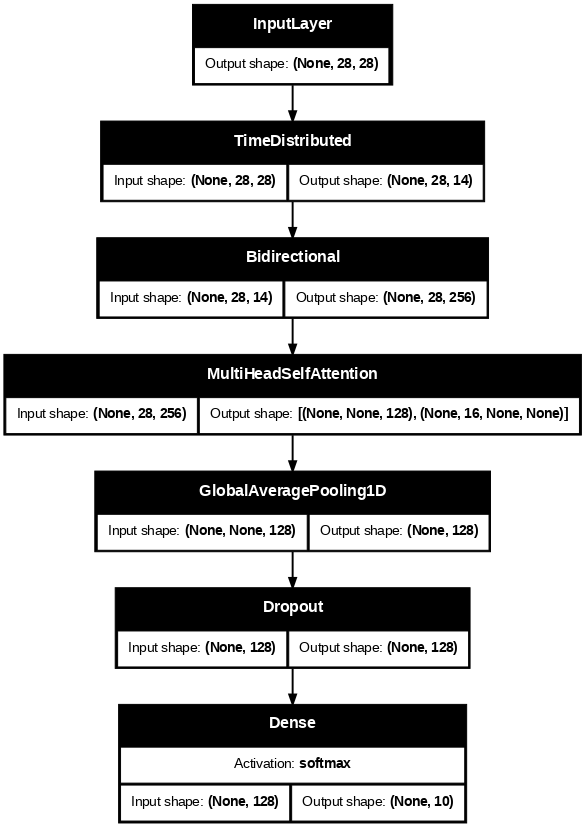

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

#### Fit

In [ ]:
%%time
batch_size = 512
history_3_5 = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=30)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.1953 - loss: 2.0938 - val_acc: 0.3355 - val_loss: 1.7616
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.3429 - loss: 1.7225 - val_acc: 0.3750 - val_loss: 1.6266
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.3946 - loss: 1.5963 - val_acc: 0.4311 - val_loss: 1.5223
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.4390 - loss: 1.4818 - val_acc: 0.4636 - val_loss: 1.4276
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.4650 - loss: 1.4133 - val_acc: 0.4795 - val_loss: 1.3875
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.4837 - loss: 1.3658 - val_acc: 0.4921 - val_loss: 1.3874
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.4861 - loss: 1.3559 - val_acc: 0.5014 - val_loss: 1.3287
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.5065 - loss: 1.3069 - val_acc: 0.5112 - val_loss: 1.3141
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/

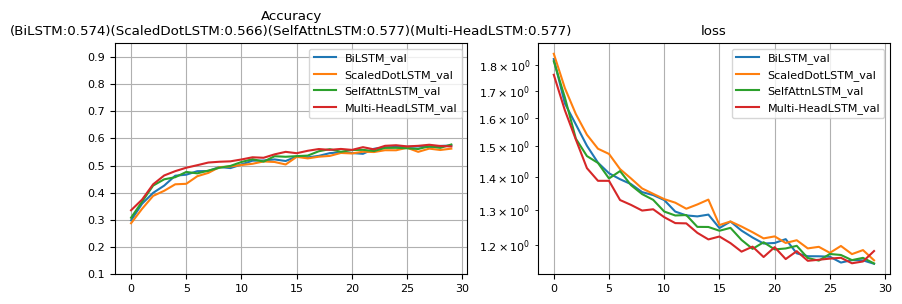

In [ ]:
titles=["BiLSTM","ScaledDotLSTM","SelfAttnLSTM","Multi-HeadLSTM"]
plt_history([history_2.history,history_3_3.history,history_3_4.history,history_3_5.history],titles,0.1)

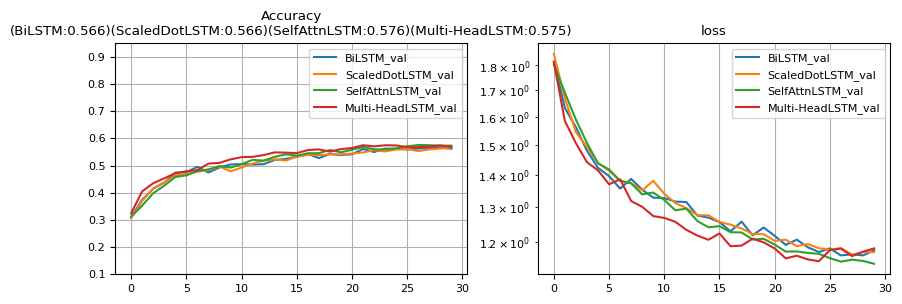

# Model Conv1d   

### **Import Module**

In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

keras.__version__

'3.8.0'

In [ ]:
# # FashionMNIST 데이터 로드 및 전처리
# (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0   # (0~1)<-(0~255)

# print(f"Original shape: {x_train.shape}")
# ps(x_test[0:3]), ps(y_test[0:3])


### Kernel size : 3

In [ ]:
### **Model-1** : 1D CNN Model
# 주요 변수 정의
kernel_size = 3        # 1D conv kernel size
pool_size = 2          # pooling size
dense_units = 128      # dense layer units
out_dense = 10         # 출력은 숫자(0~9) 확률

## Model-1 설계 : 1D CNN 모델
def model_1(kernel_size=3):
    return keras.models.Sequential([
          keras.Input(shape=(28,28)),
          layers.TimeDistributed(                   #(bs,28,64)
              layers.Dense(64, activation='relu'), name='in_dense'),
          # 첫 번째 1D Conv 블록                      (bs,28,64)
          layers.Conv1D(64, kernel_size=kernel_size, padding='same'),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.MaxPooling1D(pool_size=pool_size), #(bs,14,64)
          # 두 번째 1D Conv 블록                      (bs,14,128)
          layers.Conv1D(128, kernel_size=kernel_size, padding='same'),
          layers.ReLU(),
          layers.MaxPooling1D(pool_size=pool_size), #(bs,7,128)
          # Global Average Pooling으로 차원 축소
          layers.GlobalAveragePooling1D(),          #(bs,128)
          # Dense layers
          layers.Dense(dense_units, activation='relu'),
          layers.Dense(out_dense, activation='softmax')
    ], name="1D-CNN")

model = model_1(3)  # Model Instance
model.summary()

Model: "1D-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_dense (TimeDistributed)           │ (None, 28, 64)              │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 28, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 14, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_9           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,970 (222.54 KB)

 Trainable params: 56,842 (222.04 KB)

 Non-trainable params: 128 (512.00 B)

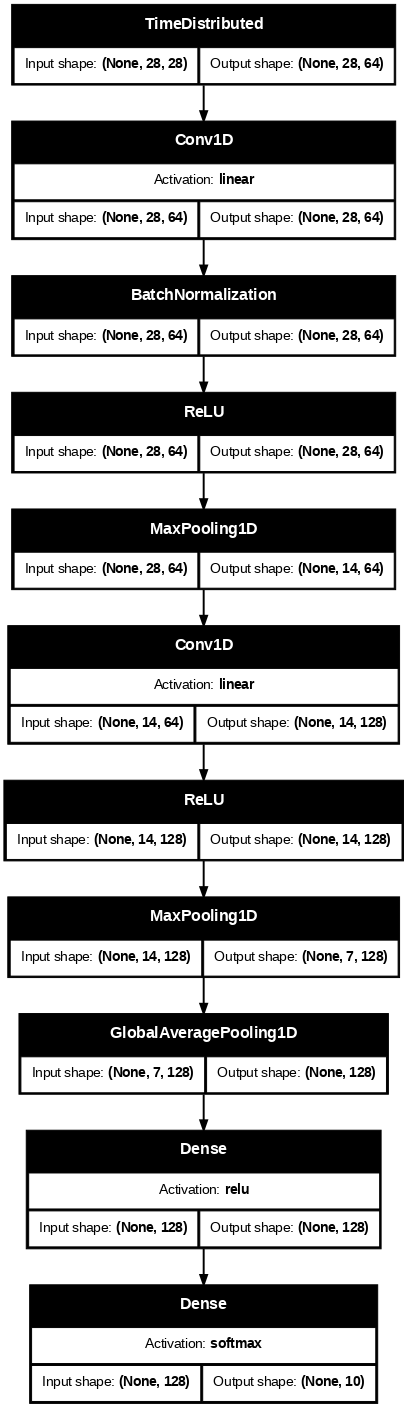

In [ ]:
# 모델 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=70)

In [ ]:
%%time
kernel_size=3
model = model_1(kernel_size)
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

batch_size = 512
history_1 = model.fit(x_train, y_train,  # 1D 형태의 데이터 사용
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=30)
# Wall time: 52.8 s

Model: "1D-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_dense (TimeDistributed)           │ (None, 28, 64)              │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 28, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 14, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_10          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,970 (222.54 KB)

 Trainable params: 56,842 (222.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - acc: 0.2986 - loss: 1.8676 - val_acc: 0.4359 - val_loss: 1.7658
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5143 - loss: 1.2961 - val_acc: 0.4913 - val_loss: 1.4236
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5621 - loss: 1.1774 - val_acc: 0.5664 - val_loss: 1.2127
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5910 - loss: 1.0972 - val_acc: 0.5929 - val_loss: 1.1232
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6094 - loss: 1.0597 - val_acc: 0.6005 - val_loss: 1.0764
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6234 - loss: 1.0090 - val_acc: 0.5825 - val_loss: 1.1384
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6381 - loss: 0.9796 - val_acc: 0.5816 - val_loss: 1.1649
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6399 - loss: 0.9714 - val_acc: 0.6295 - val_loss: 1.0009
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

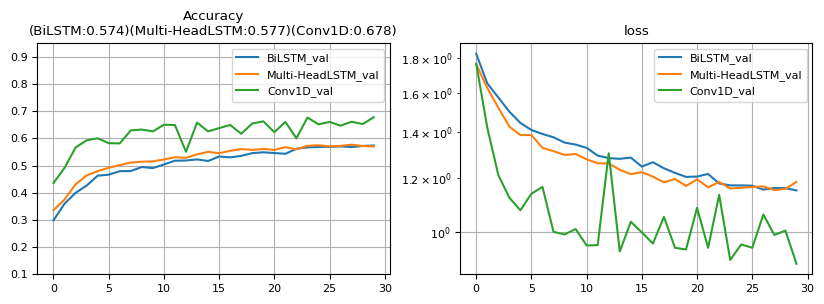

In [ ]:
titles=["BiLSTM","Multi-HeadLSTM","Conv1D"]
plt_history([history_2.history,history_3_5.history,history_1.history],titles,0.1)

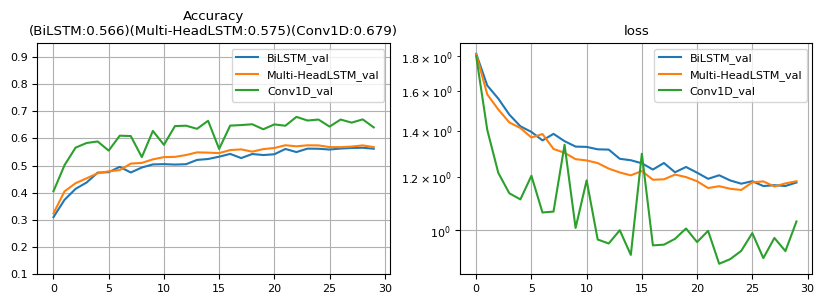